# Financial Product Classification Model Based on Received Complaints

**Presented by Dr. Juliho Castillo**.

In this project, we will analyze the [Consumer Complaints](https://www.kaggle.com/dushyantv/consumer_complaints) dataset, which includes complaints received against financial institutions in the United States over a period from 2012 to 2016.

In the first part of the work, we will manipulate and clean the data so that they are useful for analysis. In the second part, we will analyze this data in both its dimensions and its temporal behavior, to finally create a model that allows us to predict the product category based on other characteristics.

Due to time and resource constraints, we will use a sample of the entire dataset. However, the parameters with which this sample was chosen can be easily changed so that the algorithm applies to the entire dataset.


# Data Preprocessing

## Importing Modules and Data

- Let's import those that modules we will use during the project
- We check if a GPU is available
- We import the data into a dataframe df.


In [1]:
import pandas as pd
import numpy as np
import string
from collections import Counter
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns

%pip install GPUtil
import GPUtil

#!pip install xgboost
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

#!pip install plotly
import plotly.offline as py
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

warnings.filterwarnings("ignore")

  Preparing metadata (setup.py) ... - \ done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=26c1a28feb308c9443cf3dc5421327466c9d79d3a63c8edaf17148919e2818a5
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
Note: you may need to restart the kernel to use updated packages.


In [2]:
GPUs = GPUtil.getGPUs()
GPUavailability = GPUtil.getAvailability(GPUs, maxLoad = 0.5, maxMemory = 0.5, includeNan=False, excludeID=[], excludeUUID=[])
GPUavailability

[1]

In [3]:
gpu = bool(GPUtil.getAvailable())

In [4]:
gpu

True

In [5]:
filepath = "/kaggle/input/consumer_complaints/Consumer_Complaints.csv"
df = pd.read_csv(filepath)
rows = df.shape[0]

* Due to memory limits, we are going to take a sample of the database.
* The highest percentage (rounded) that could be used is 35%.
* The variable 'samples' tells us how many records our sample contains.
* Upon importing the dataframe, we are shown a warning about these two columns. We will deal with them later.
* The function `cool_col` will transform the name of each column so that it is easier to use.
* We transform the name of all the columns.
* The variable ubanks is the set of bank names sorted alphabetically.


In [6]:
pct = 0.15
magic_number = int(pct*rows)
df = df.sample(n=magic_number, random_state=0)
samples = df.shape[0]

In [7]:
df.columns[[5,11]]

Index(['Consumer Complaint', 'Consumer consent provided?'], dtype='object')

In [8]:

def cool_col(col):
    col = col.replace("-", " ")
    col = col.replace("?", "")
    phrase = col.split()
    tag = None
    if len(phrase)==1:
        tag = phrase[0]
    else:
        tag = phrase[0]+"_"+phrase[1]    
    #print(col, phrase, tag)
    return tag.lower()

In [9]:

df.columns = [cool_col(col) for col in df.columns]

In [10]:

ubanks = np.sort(pd.unique(df["company"]))

## Variable Processing

- We will remove the complaint ID as it does not provide relevant information.
- We will only work with variables that have less than 20% null values.






In [11]:

df.drop(columns = ['complaint_id'], inplace=True)

In [12]:
to_include = df.columns[(df.isnull().sum()<(0.20)*samples).values]

In [13]:
to_include

Index(['date_received', 'product', 'issue', 'company', 'state', 'zip_code',
       'submitted_via', 'date_sent', 'company_response', 'timely_response'],
      dtype='object')

In [14]:
df = df[to_include]

### Company

- Now we will transform the "company" variable, trying to identify banks that belong to the same group and that vary in name under certain circumstances. 
- For example, because they are located in two different states.
- We identify special characters that will be replaced.
- We look for the most common suffixes.








In [15]:
non_special = {ord(c):"" for c in string.punctuation}

In [16]:

common_suffixes = set()
for bank in ubanks[0]:
    if "," in bank:
        last_comma = bank.rindex(",")       
        suffix = bank[last_comma+1:].strip()
        suffix_words = suffix.split()
        if "&" not in suffix_words and "and" not in suffix_words:
           common_suffixes.add(suffix)           
#common_suffixes.remove("")
common_suffixes = sorted(common_suffixes, key=len)[::-1]

- This function will help us clean up a bank’s title to identify names that are similar.
- The `bank_tags` dictionary will provide us a way to identify each original bank title with its clean title.
- We replace the bank names with the previous dictionary.





In [17]:

def clean_title(title):
    title = title.translate(non_special).lower()
    title = title.replace("the", "")
    title = title.replace("of", "")
    title = title.replace("&", "")
    title = title.replace("and", "")
    title = "_".join([word for word in title.split() if len(word)>1])
    return title

In [18]:

bank_tags = {}
for bank in ubanks:
    new = bank
    for suffix in common_suffixes:
        new = new.replace(suffix, "")
    if clean_title(new):
        bank_tags[bank] = clean_title(new)
    else:
        tag = bank.split()[0].translate(non_special).lower()      
        #print("{:<30} {:<10} {} {:>10}".format(bank,new,clean_title(new),tag))                
        bank_tags[bank] = tag

In [19]:

df.company=df["company"].replace(bank_tags)

### Date received/Date sent to company

- We convert the complaint receipt date from string type to timestamp type. 
- We convert the complaint submission date to the bank from string type to timestamp type.
- We look for the most recent date in the data frame. 
- This new data column contains the number of days elapsed from when the complaint was received until the most recent date.
- This new data column contains the number of days elapsed from when the complaint was sent to the bank until the most recent date.

In [20]:

df["date_received"] = df["date_received"].str.replace('/', '-')
df.date_received = pd.to_datetime(df["date_received"])

In [21]:

df["date_sent"] = df["date_sent"].str.replace('/', '-')
df.date_sent = pd.to_datetime(df["date_sent"], format="%m-%d-%Y")

In [22]:

today = max(df.date_received.max(), df.date_sent.max())

In [23]:

df["received_days"] = (today-df.date_received)/np.timedelta64(1, 'D')

In [24]:

df["sent_days"] = (today-df.date_sent)/np.timedelta64(1, 'D')

## Transformation to Categorical Variables
### Object Variables
- We identify the variables of the object type
- We create a matrix where only the object type variables are included
- We create a matrix where only the object type variables are included
- We convert all variables to categorical.

In [25]:

df.select_dtypes(include=['object']).columns

Index(['product', 'issue', 'company', 'state', 'zip_code', 'submitted_via',
       'company_response', 'timely_response'],
      dtype='object')

In [26]:

X = df.select_dtypes(include=['object'])

In [27]:
X.drop(columns = ["product"], inplace=True)

In [28]:

X = X.astype('category')

### Numeric Variables
- We identify the numeric variables
- We add these variables to our matrix
- We check how many null values our columns have.

In [29]:
df._get_numeric_data().columns

Index(['received_days', 'sent_days'], dtype='object')

In [30]:

X = pd.concat([X,df._get_numeric_data()], axis=1)

In [31]:

X.isnull().sum()

issue                  0
company                0
state               1816
zip_code            2474
submitted_via          0
company_response       1
timely_response        0
received_days          0
sent_days              0
dtype: int64

We separate each numeric variable into quartiles. The category of each record will correspond to its quartile. This will allow us to make all records categorical variables which we will later transform into binary vectors

In [32]:

for col in df._get_numeric_data().columns:
    X[col] = pd.qcut(X[col], 4).astype("category")

## Encoding
We will encode the categories of each column as natural numbers.

In [33]:
encoder = {}
for col in X.columns:
    encoder[col] = preprocessing.LabelEncoder()
    temp = X[col].values
    X[col] = encoder[col].fit_transform(temp)

### OneHot Encoding
Due to memory constraints, we will only work with three predictor variables. These variables were chosen manually, to illustrate how to visualize and analyze data. However, they could be chosen objectively using a method like RFE (Recursive Feature Elimination).
- We will transform the categorical variables into binary vectors.
- We will do something similar with the data frame.
- Finally, we will create an auxiliary column that will help us with the counts.

In [34]:
to_select = ['issue', 'company', 'received_days']

In [35]:
X = X[to_select]

In [36]:
ohc = preprocessing.OneHotEncoder(sparse_output = False)
X = ohc.fit_transform(X.values)

In [37]:
df = df[to_select+["product", "date_received", "state"]]

In [38]:
df["count"] = 1

## Response Processing
- We save the target column in target
- We verify that there are no null values in the response variable.
- We encode the response variable and save the transformation in the variable y
- Due to memory constraints, we will eliminate the target series.

In [39]:
target = df["product"]

In [40]:
target.isnull().sum()

0

In [41]:
encoder["product"] = preprocessing.LabelEncoder()
y = encoder["product"].fit_transform(target)

In [42]:
del target

## Training and Test Sets
- We separate our predictor matrix and the response vector into test and training sets.
- Due to memory constraints, we will eliminate both the X matrix and the y matrix.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [44]:
del X

In [45]:
del y

# Modeling 

## Requirements 

- Present one or several descriptive statistics that give an idea of how the data behaves (over time, in space, in both dimensions; by bank name, type of complaint, etc.) 
- The statistics should be accompanied by a brief explanation that makes sense of them. 
- As part of the previous instruction, create one or several visualizations that you think are important to understand the database. 
- Be selective, so that your visualization(s) tell a story with the data. You can use dynamic visualizations (plotly, bokeh, etc.) or static ones (matplotlib, seaborn, plotnine etc.)

### Complaints by Location

We are going to visualize the number of complaints by state. As you can see, California is the state with the most complaints.

In [46]:
states = df.groupby(["state"]).count()[["issue"]]

In [47]:
states["issue"]

state
AA       2
AE      65
AK     185
AL    1682
AP      45
      ... 
VT     218
WA    3078
WI    1616
WV     394
WY     139
Name: issue, Length: 62, dtype: int64

In [48]:
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = states.index,
        z = states['issue'].astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Número de quejas"
        )
    ) ]

layout = dict(
        title = 'Quejas por estado',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )
    
fig = dict( data=data, layout=layout )

url = py.iplot( fig , filename='d3-cloropleth-map.html')

### Complaints Over Time

- First, let’s observe the distribution of complaints over time.
- Then we will analyze the temporal behavior of complaints using time series. For this section, I followed the article [An End-to-End Project on Time Series Analysis and Forecasting with Python](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b), adapting it to our data.
- We will cut the data up to October 31, 2016, as the information for November is incomplete, and we do not have data after this month.
- We group the data by date; we count the complaints per day and resample them by month.
- We will visualize the time series
- We look for optimal parameters for our SARIMAX model
- Finally, we visualize the forecasts vs the actual data for 2016

<Axes: xlabel='date_received', ylabel='Density'>

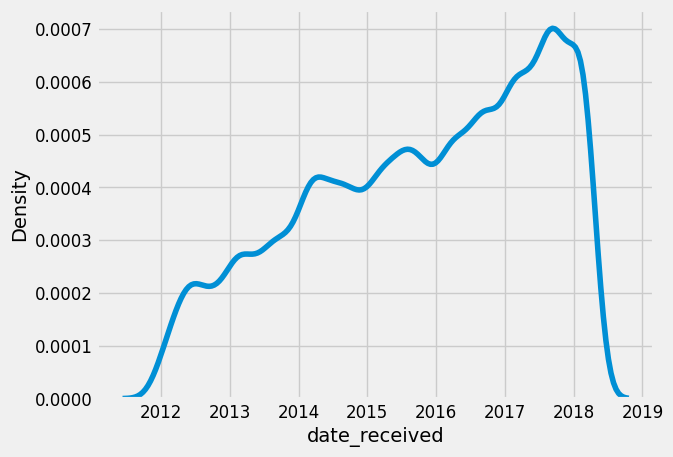

In [49]:
sns.kdeplot(df["date_received"])

In [50]:
top_date = pd.to_datetime('2016-10-31')

In [51]:
ts = df[["date_received", "count"]].groupby("date_received").sum()[:top_date].resample("MS").sum()
ts.tail()

,count
date_received,
2016-06-01,2338
2016-07-01,2414
2016-08-01,2681
2016-09-01,2661
2016-10-01,2696


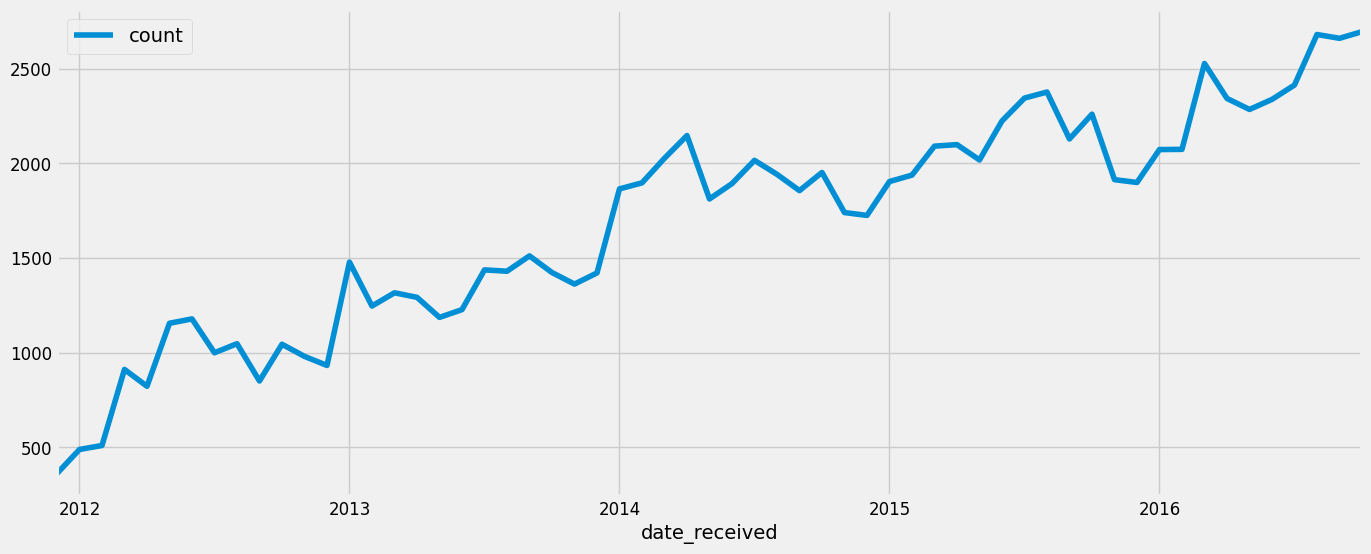

In [52]:
ts.plot(figsize=(15, 6))
plt.show()

In [53]:
warnings.filterwarnings("ignore")

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

opt_param = None
opt_param_seasonal = None
opt_results = None
opt_aic = np.inf

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < opt_aic:
                opt_param = param
                opt_param_seasonal = param_seasonal
                opt_results = results
                opt_aic = results.aic
        except:
            continue

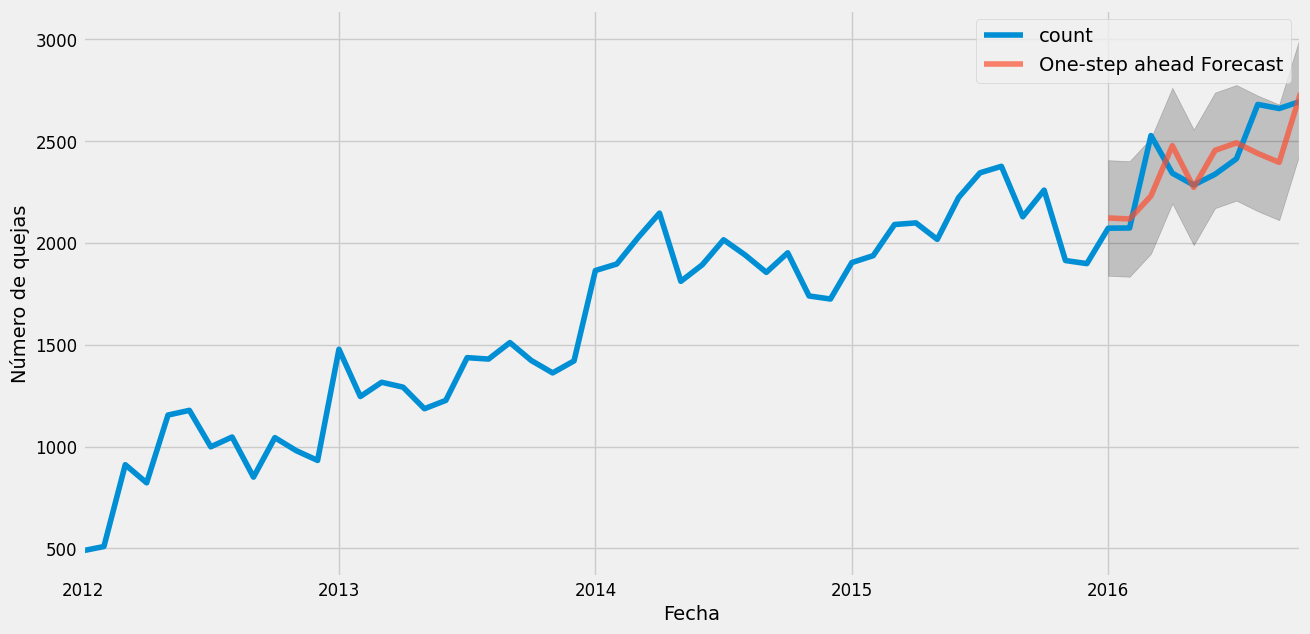

In [54]:
pred = opt_results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ts['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Número de quejas')
plt.legend()
plt.show()

## Frequency of Complaints by Bank
Using an "edit-distance" algorithm or any other that you consider relevant, normalize the names of the banks and generate a bar graph that shows the frequency of complaints by bank.

### Top 10 Complaints by Product

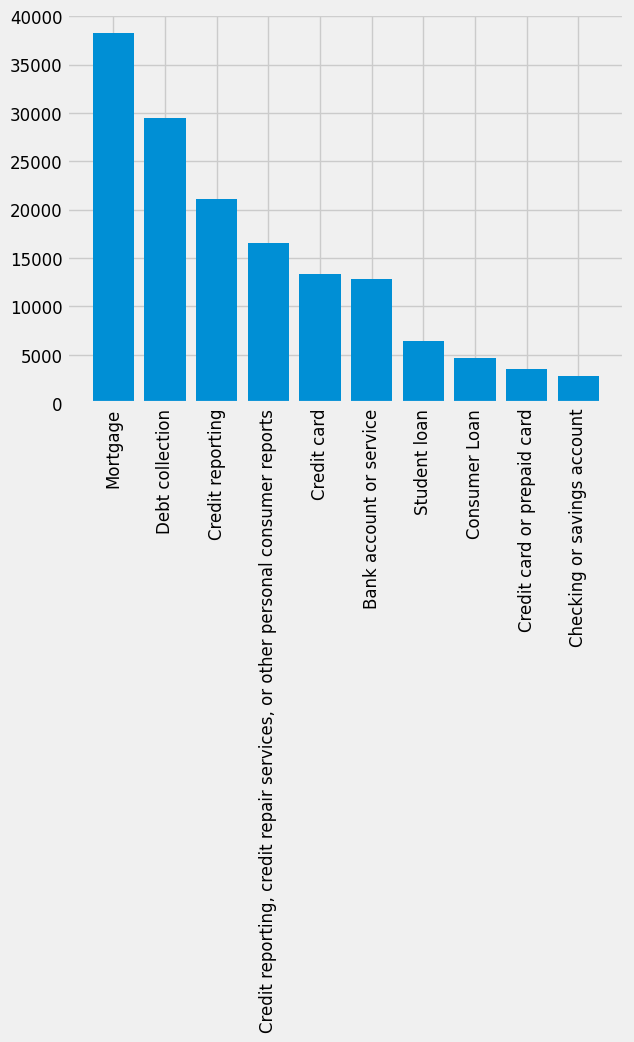

In [55]:
counter = Counter(df["product"])
top10_productos = OrderedDict(counter.most_common(10))
plt.bar(list(top10_productos.keys()), list(top10_productos.values()))
plt.xticks(rotation=90)
plt.show()

### Top 10 complaints by bank

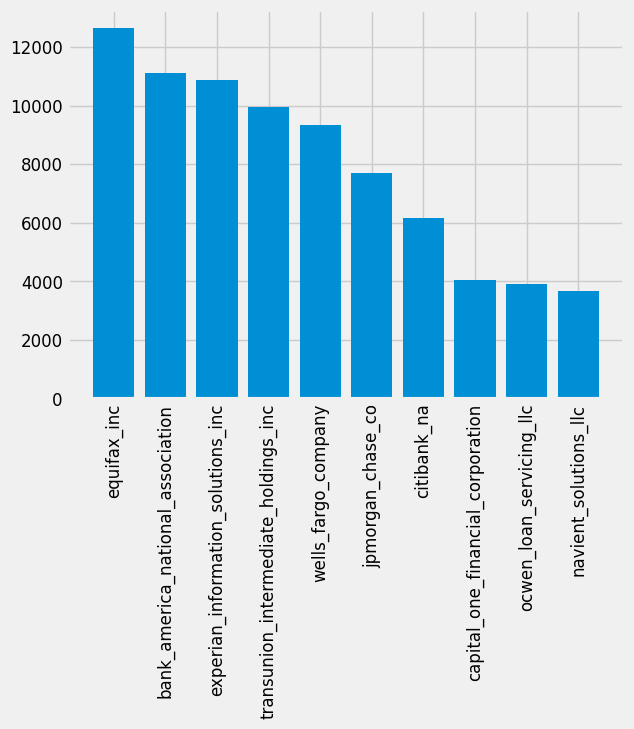

odict_keys(['equifax_inc', 'bank_america_national_association', 'experian_information_solutions_inc', 'transunion_intermediate_holdings_inc', 'wells_fargo_company', 'jpmorgan_chase_co', 'citibank_na', 'capital_one_financial_corporation', 'ocwen_loan_servicing_llc', 'navient_solutions_llc'])

In [56]:
counter = Counter(df["company"])
top10_bancos = OrderedDict(counter.most_common(10))
plt.bar(list(top10_bancos.keys()), list(top10_bancos.values()))
plt.xticks(rotation=90)
plt.show()
top10_bancos.keys()

### Top 10 complaints by bank/product

In [57]:
df.groupby(["company", "product"]).count()[["count"]].sort_values(by=["count"], ascending=False).head(n = 10)

,,count
company,product,
equifax_inc,Credit reporting,7231
experian_information_solutions_inc,Credit reporting,6822
bank_america_national_association,Mortgage,6228
transunion_intermediate_holdings_inc,Credit reporting,6004
equifax_inc,"Credit reporting, credit repair services, or other personal consumer reports",5269
wells_fargo_company,Mortgage,5088
experian_information_solutions_inc,"Credit reporting, credit repair services, or other personal consumer reports",3929
transunion_intermediate_holdings_inc,"Credit reporting, credit repair services, or other personal consumer reports",3831
ocwen_loan_servicing_llc,Mortgage,3786


## Recurring topics
What topics do the complaints talk about?

### Top ten complaints by subject

In [58]:
df[["issue", "count"]].groupby(["issue"]).count().sort_values(by=["count"], ascending=False).head(n=10)

,count
issue,
"Loan modification,collection,foreclosure",17018
Incorrect information on credit report,15391
"Loan servicing, payments, escrow account",11480
Incorrect information on your report,9164
Cont'd attempts collect debt not owed,9110
"Account opening, closing, or management",5622
Disclosure verification of debt,4643
Communication tactics,4459
Problem with a credit reporting company's investigation into an existing problem,3695


### Complaints by bank/issue

In [59]:
pd.pivot_table(df, values="count", index=["company"], columns=["issue"], aggfunc=np.sum, fill_value=0)

issue,APR or interest rate,"Account opening, closing, or management",Account terms and changes,Adding money,Advertising,Advertising and marketing,"Advertising and marketing, including promotional offers","Advertising, marketing or disclosures",Application processing delay,"Application, originator, mortgage broker",...,Unauthorized transactions/trans. issues,Unexpected or other fees,Unexpected/Other fees,Unsolicited issuance of credit card,Using a debit or ATM card,Vehicle was damaged or destroyed the vehicle,Vehicle was repossessed or sold the vehicle,"Was approved for a loan, but didn't receive the money",Written notification about debt,Wrong amount charged or received
company,,,,,,,,,,,,,,,,,,,,,
1st_alliance_lending_llc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1st_fidelity_loan_servicing,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1st_financial_inc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1st_franklin_financial_corporation,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1st_maryl_mortgage_corporation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zenith_financial_network_inc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zeus_mortgage_ltd,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
zions_bancorporation,0,10,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


## Data dimension
Develop an unsupervised learning model to understand a dimension of data in which they are clearly clusterable.

### PCA

In this first step, we are going to perform a principal component analysis of our training matrix. We will choose the two components that best explain the variance, to be able to visualize them. Each data will be projected onto these two components, giving us the coordinates for grouping.

In [60]:
n,p = X_train.shape
n

123000

In [61]:
pca = PCA(n_components=2)

In [62]:
X_train_sample = X_train[np.random.choice(X_train.shape[0], int(0.10*X_train.shape[0]), replace=False), :]

In [63]:
X_pca = pca.fit_transform(X_train_sample)

In [64]:
explained_ratio = pca.explained_variance_ratio_

In [65]:
np.add.accumulate(explained_ratio)

array([0.11161521, 0.20828747])

In [66]:
e1, e2 = pca.components_

In [67]:
p = len(e1)

### Clustering

In this second step, we will group the data, with its coordinates given by the two principal components, using the k-means algorithm. We will choose the number of clusters according to the distortion diagram, right at the point where the "elbow" of the graph is formed.

In [68]:
x0 = X_pca[:,0].ravel()

In [69]:
x1 = X_pca[:,1].ravel()

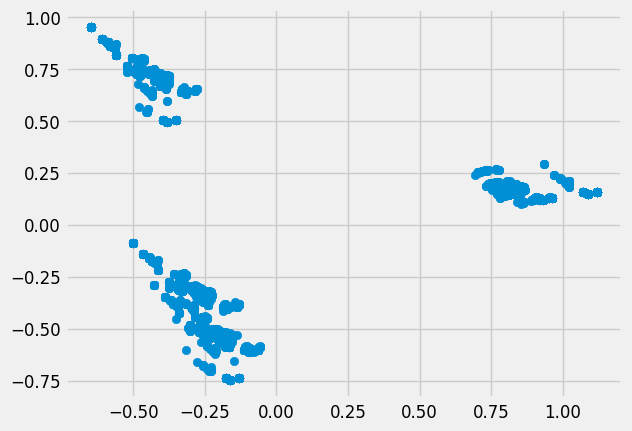

In [70]:
plt.scatter(x0,x1)

In [71]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X_pca)
    distortions.append(km.inertia_)

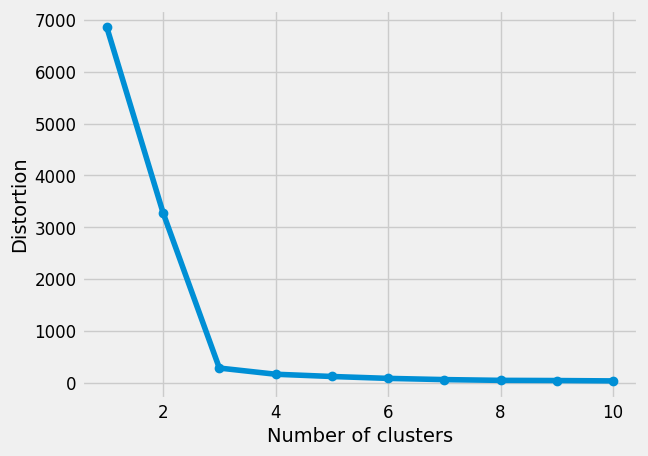

In [72]:
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [73]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_pca)

In [74]:
clusters = kmeans.predict(X_pca).ravel()

<Axes: >

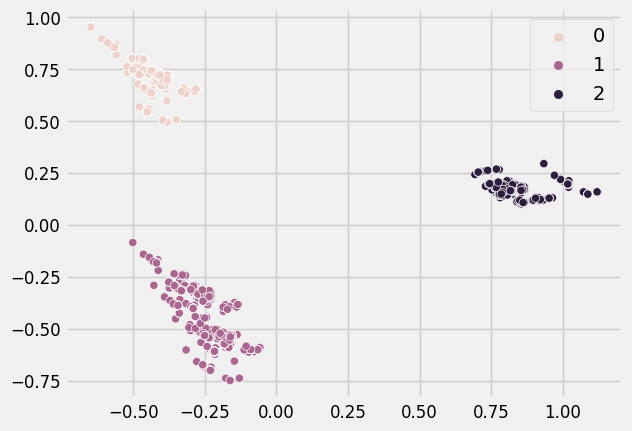

In [75]:
sns.scatterplot(x=x0, y=x1, hue=clusters)

In [76]:
del X_pca

## Predictions based on machine learning

Develop a machine learning model that predicts the type of product based on the text. You can use any technique you want, but you must explain what evaluation metrics you use to determine your choice of model.

### XGBoost

- For this question I chose the XGBoost classifier. According to the article [A Gentle Introduction to XGBoost for Applied Machine Learning](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/):
- XGBoost is an algorithm that has recently dominated applied machine learning and Kaggle competitions for structured or tabular data.
- XGBoost is a gradient-driven decision tree implementation designed for speed and performance.
- The XGBoost classifier has an implementation that is capable of using a GPU device, which will allow us to considerably accelerate the training.

In [77]:
if gpu:
    xgb_cl = xgb.XGBClassifier(use_label_encoder=False,
                            tree_method='gpu_hist',
                            max_bin = 16, 
                            predictor = 'gpu_predictor',
                            nthread = 4
                            )
else:
    xgb_cl = xgb.XGBClassifier(use_label_encoder=False)

In [78]:
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=16,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

### Metrics
Finally we will use different metrics to validate our model, comparing the predictions with the real categories of each product.

We will show an automated classification reporter. Although it is beyond the scope of this report to explain each metric, it is enough to understand that the closer each metric is to 1.00, the "better" the model is. See [Classification Report Explained](https://williamking112.medium.com/classification-report-explained-38aa21767b3f).

However, we will pay particular attention to [accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy), which is nothing other than the correct number of predictions over the total of the predictions made.

In [79]:
preds = xgb_cl.predict(X_test)

In [80]:

print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2479
           1       1.00      0.99      0.99       543
           2       0.98      0.99      0.99       959
           3       0.98      0.99      0.99      2657
           4       0.98      0.94      0.96       708
           5       1.00      1.00      1.00      4213
           6       0.96      1.00      0.98      3304
           7       1.00      1.00      1.00      5904
           8       0.98      0.96      0.97       181
           9       0.96      0.99      0.98       161
          10       1.00      0.99      0.99      7717
          11       0.81      0.77      0.79        22
          12       0.95      0.99      0.97       192
          13       0.92      0.75      0.82       126
          14       0.99      0.96      0.97       118
          15       1.00      0.98      0.99      1300
          16       0.91      0.83      0.87       167

    accuracy              

In [81]:
accuracy_score(y_test, preds)

0.9906669701798315

# Conclusions

In this project, we have built a model to predict the type of product about which a complaint has been received, based on predictors such as the bank, the subject of the complaint, and the date of receipt.

Although time and computational resource restrictions limited us to analyzing a part of the set, this can be solved by accessing more resources, for example in the cloud, or using algorithms that allow working with massive data, adapting the algorithm to the available packages. For this end.

Finally, our model allowed accuracy in the test set, which allows us to think that it has correctly generalized the pattern of the data, which is why it is proposed as a viable solution to the problem.